In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from skimage.util import random_noise
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.metrics import mean_squared_error
from skimage.filters import unsharp_mask
from skimage.metrics import peak_signal_noise_ratio
from skimage import data, color
import cv2

C:\Users\akash\.conda\envs\akash\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


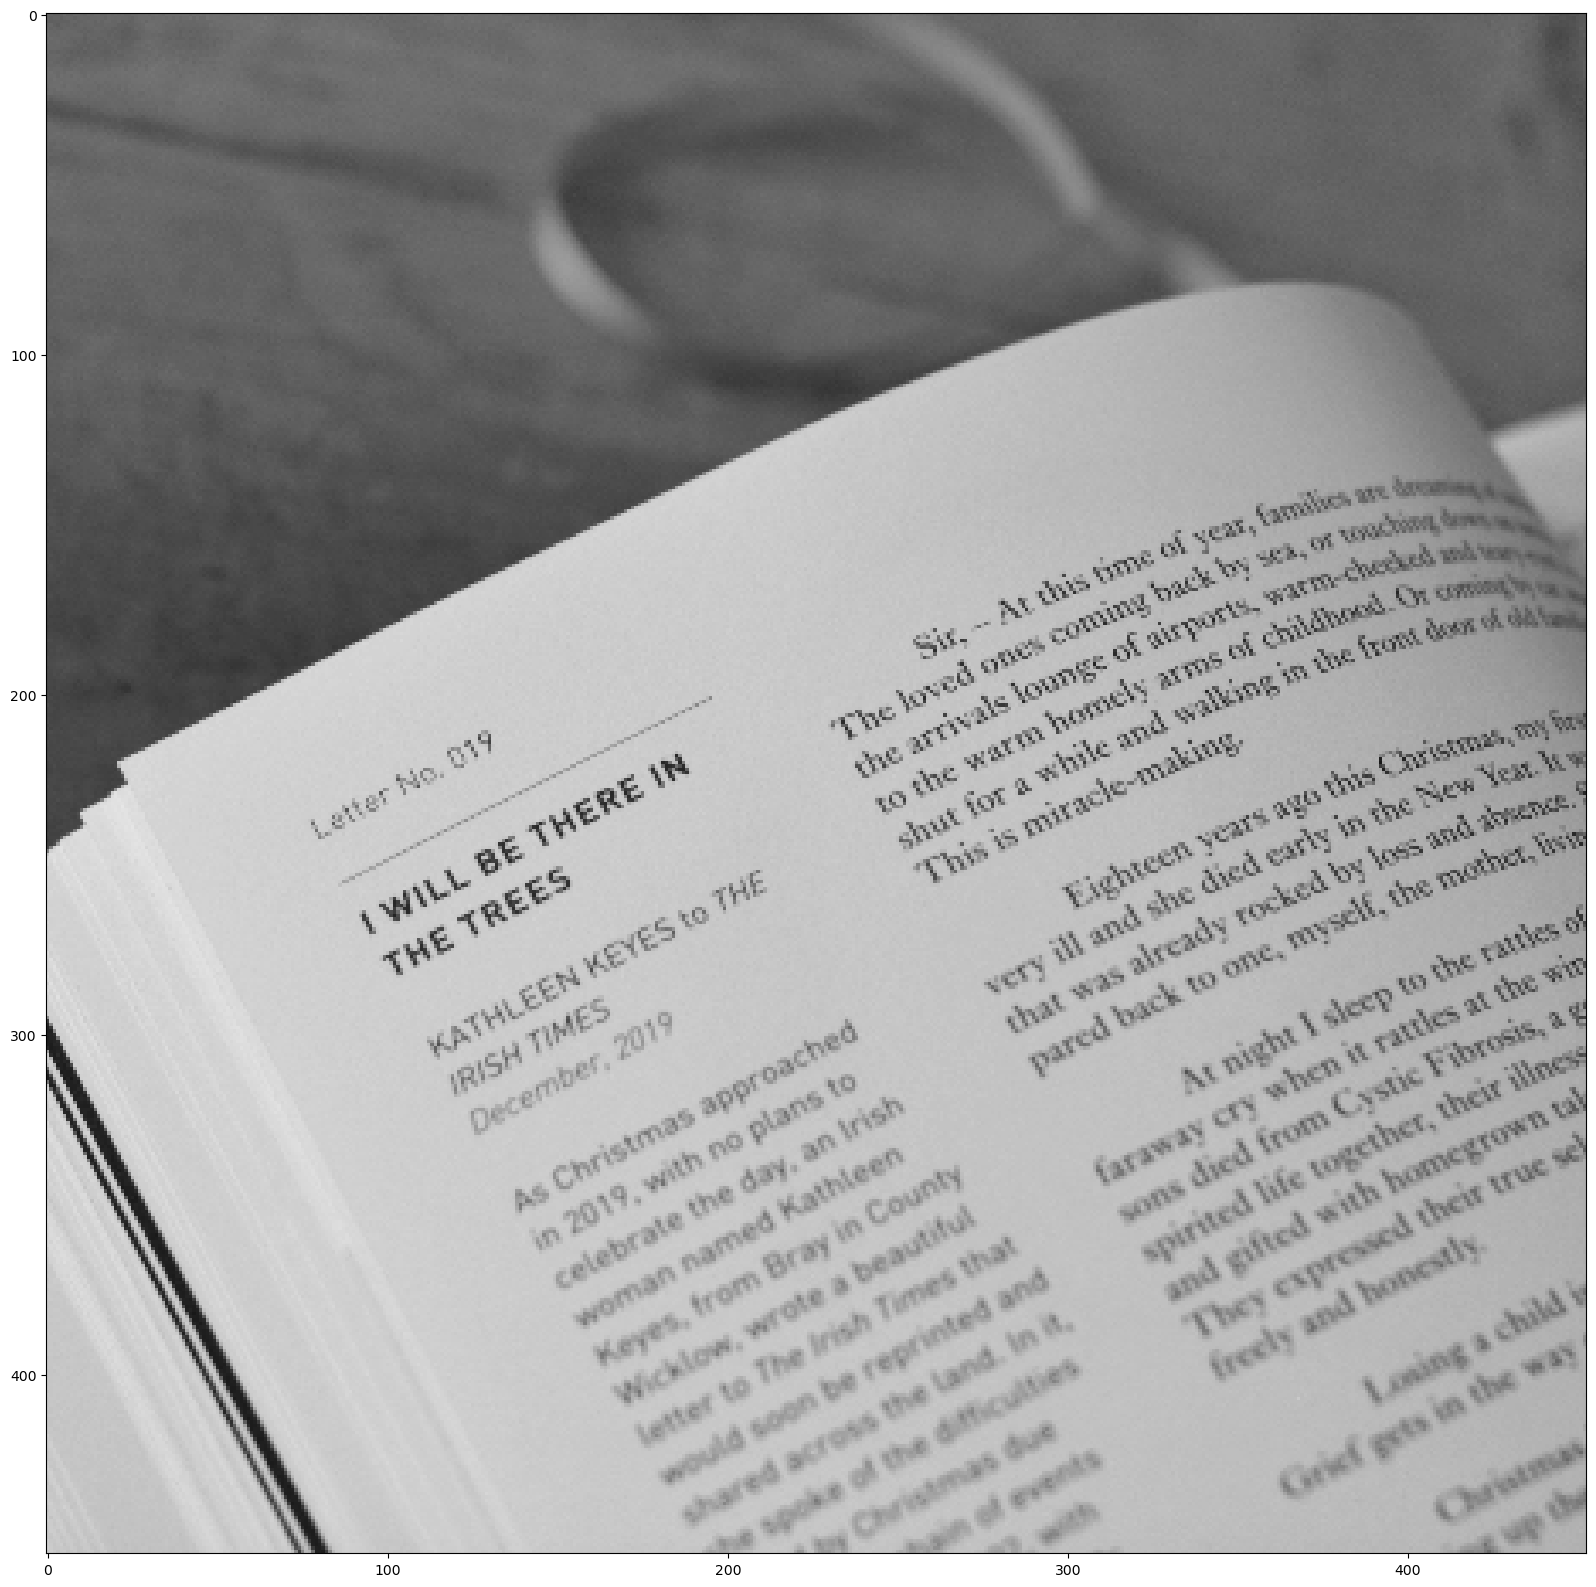

In [3]:
# Load image
image = cv2.imread('test.jpg', cv2.IMREAD_GRAYSCALE) / 255.0
# image = color.rgb2gray(data.chelsea())
# image = data.chelsea()
# downsample for higher speed
image = (
    image[::4, ::4]
    + image[1::4, ::4]
    + image[::4, 1::4]
    + image[1::4, 1::4]
)
image /= 4.0
height, width = image.shape
plt.figure(figsize=(20, 20))
plt.imshow(image, vmax=1, vmin=0, cmap=plt.cm.gray)
plt.show()

(453, 453)


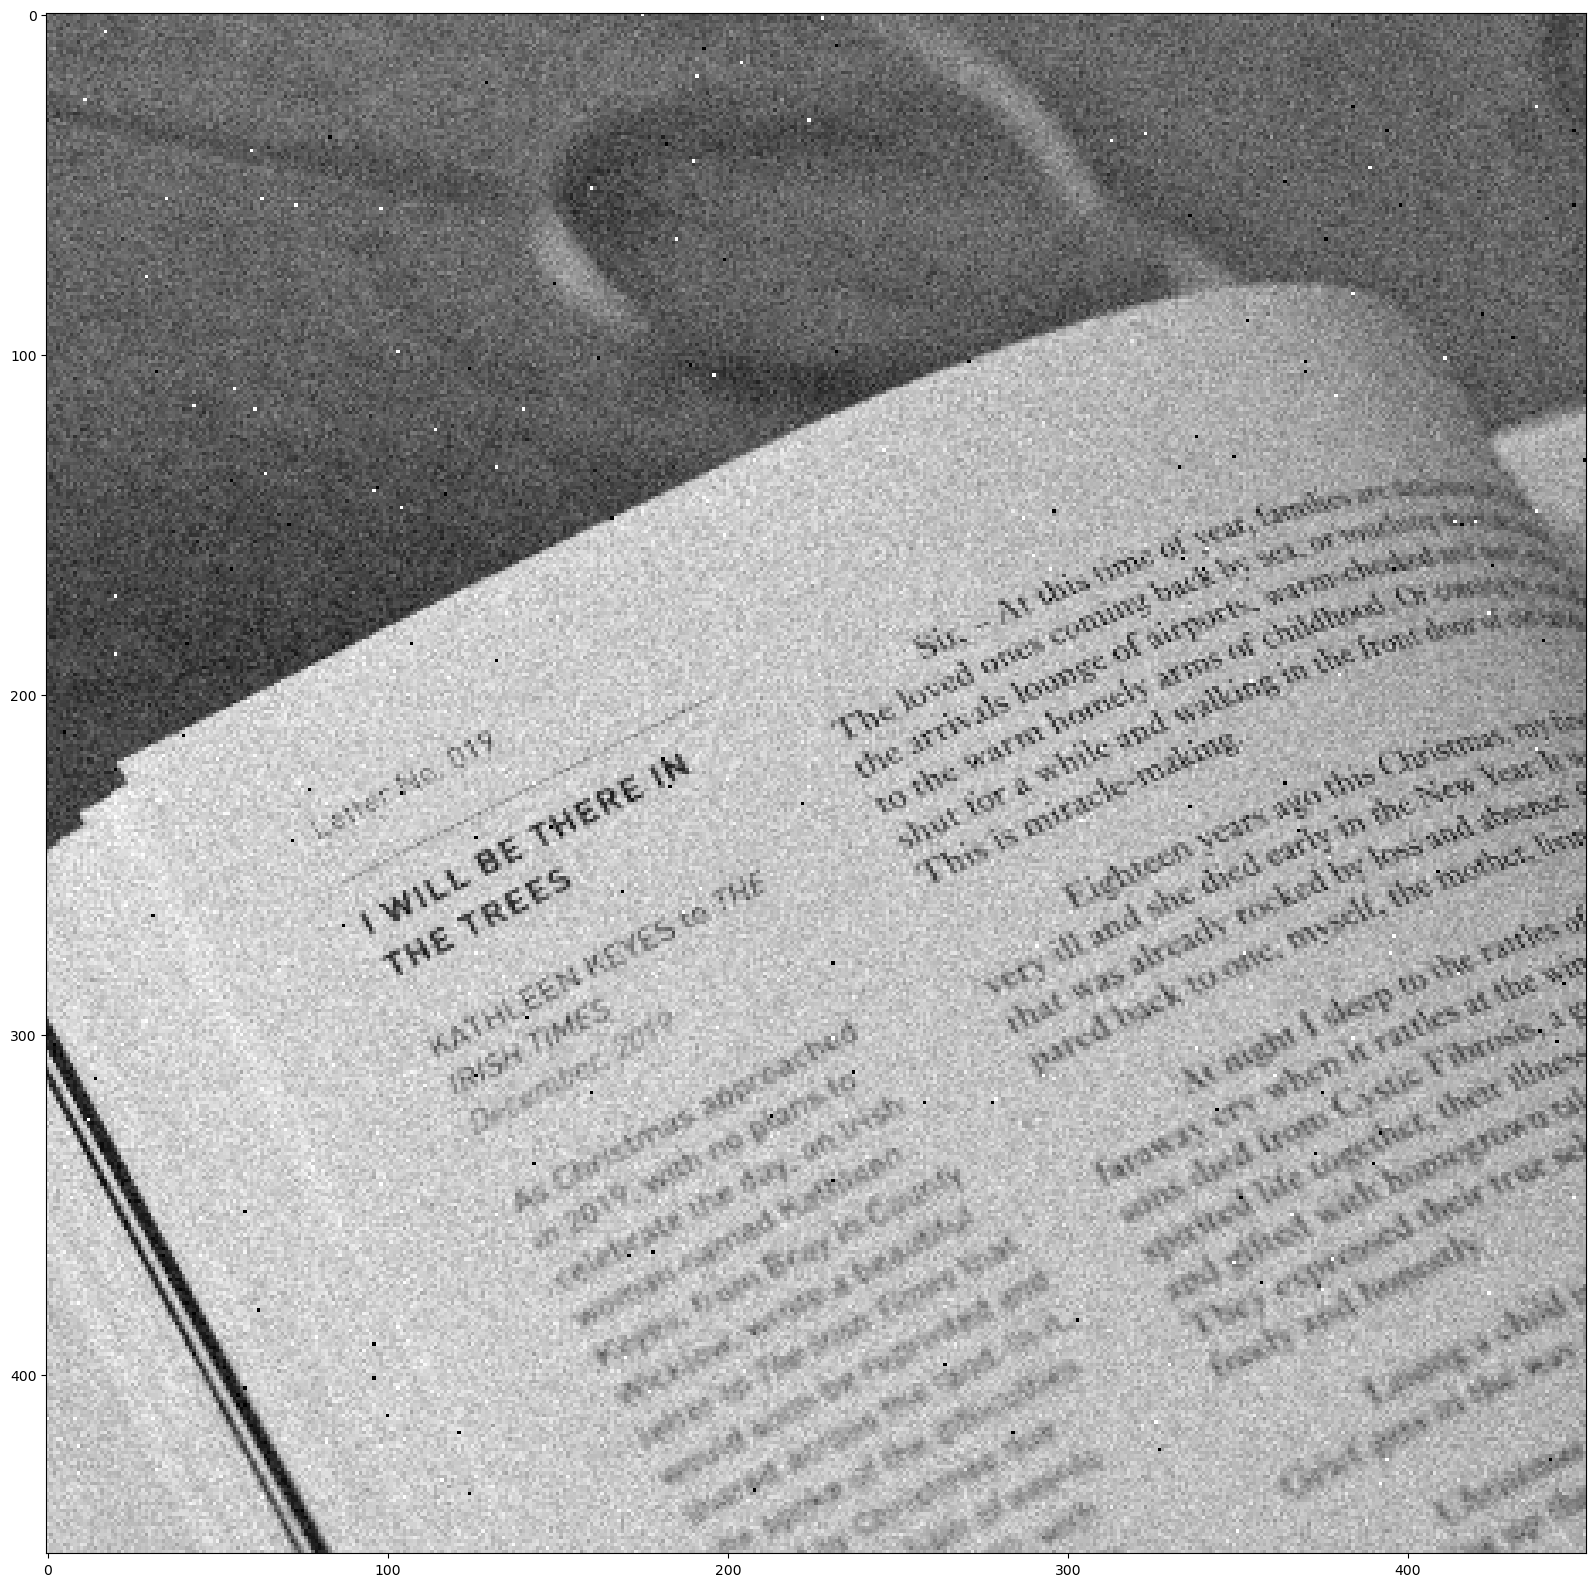

In [4]:
# Add noise to the image
noisy_image = random_noise(image, mode='gaussian', clip=True, var=0.003)
noisy_image = random_noise(noisy_image, mode='s&p', amount=0.001)
print(noisy_image.shape)
plt.figure(figsize=(20, 20))
plt.imshow(noisy_image, vmax=1, vmin=0, cmap=plt.cm.gray)
plt.show()

In [5]:
# Extract patches from the original and noisy images
noisy_patches = extract_patches_2d(noisy_image, patch_size=(7, 7), random_state=42)
original_patches = extract_patches_2d(image, patch_size=(7, 7), random_state=42)

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(noisy_patches.reshape(-1, 7*7), original_patches.reshape(-1, 7*7), test_size=0.2)

In [7]:
# Initialize and train a Ridge Regression model
model = Ridge(alpha=1)
model.fit(X_train, y_train)

Ridge(alpha=1)

In [8]:
mean_squared_error(y_test, model.predict(X_test))

0.0013391797391626066

In [9]:
# Denoise each patch using the model
denoised_patches = model.predict(noisy_patches.reshape(-1, 7*7)).reshape(-1, 7, 7)

In [10]:
# Reconstruct the image from the denoised patches
denoised_image = reconstruct_from_patches_2d(denoised_patches, image_size=(height, width))

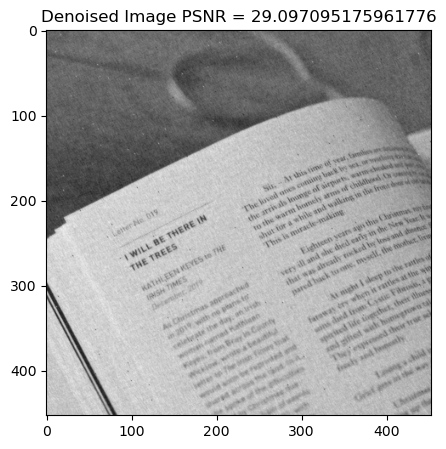

In [11]:
# Display Denoised image
plt.figure(figsize=(5, 5))
plt.imshow(denoised_image, vmax=1, vmin=0, cmap=plt.cm.gray)
plt.title("Denoised Image PSNR = " + str(peak_signal_noise_ratio(image, denoised_image)))
plt.show()

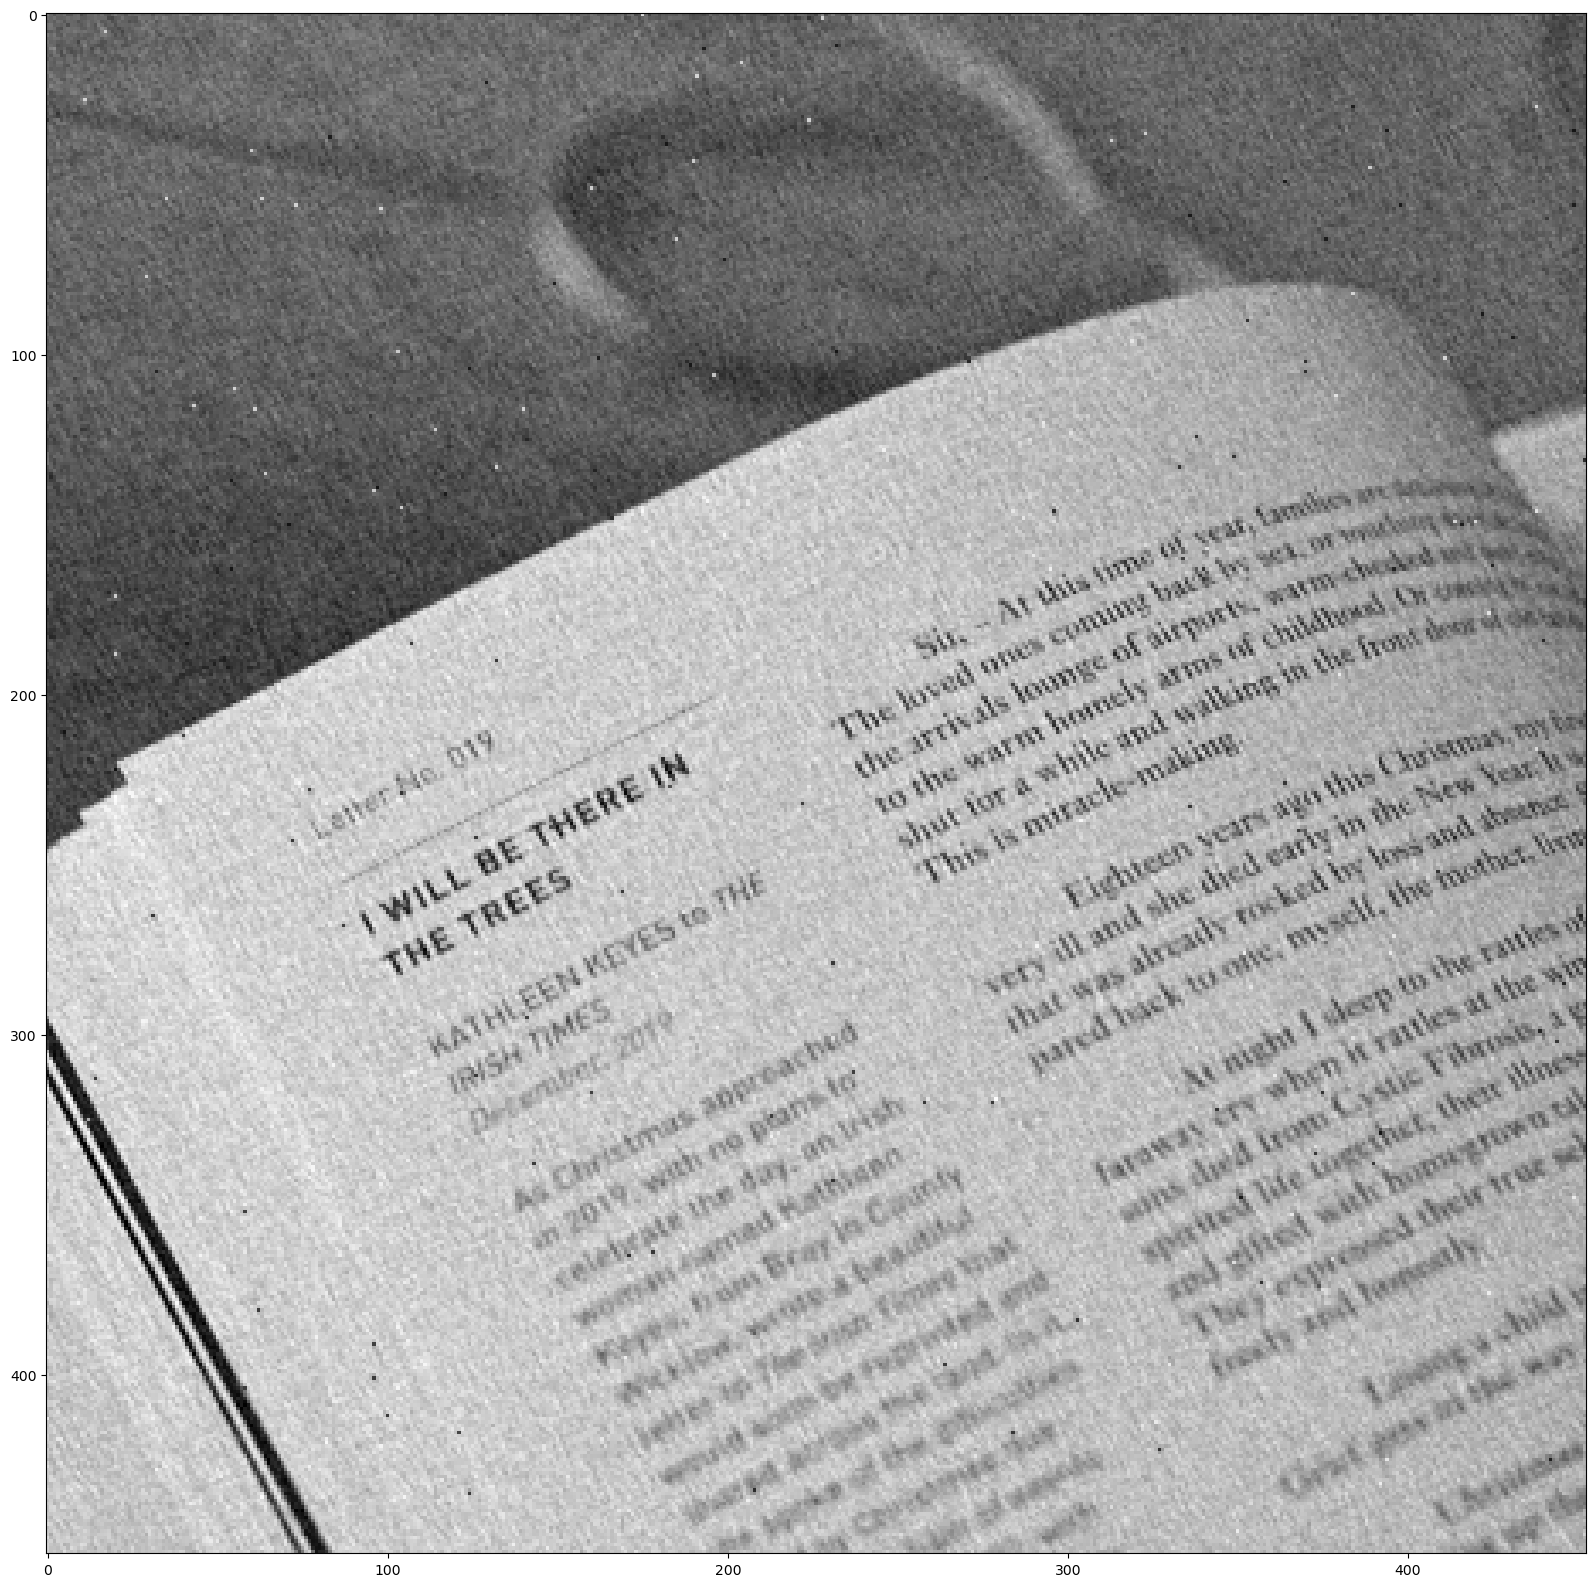

In [12]:
# Sharpen the image
sharpened_image = unsharp_mask(denoised_image, radius=1, amount=1)
plt.figure(figsize=(20, 20))
plt.imshow(sharpened_image, vmax=1, vmin=0, cmap=plt.cm.gray)
plt.show()

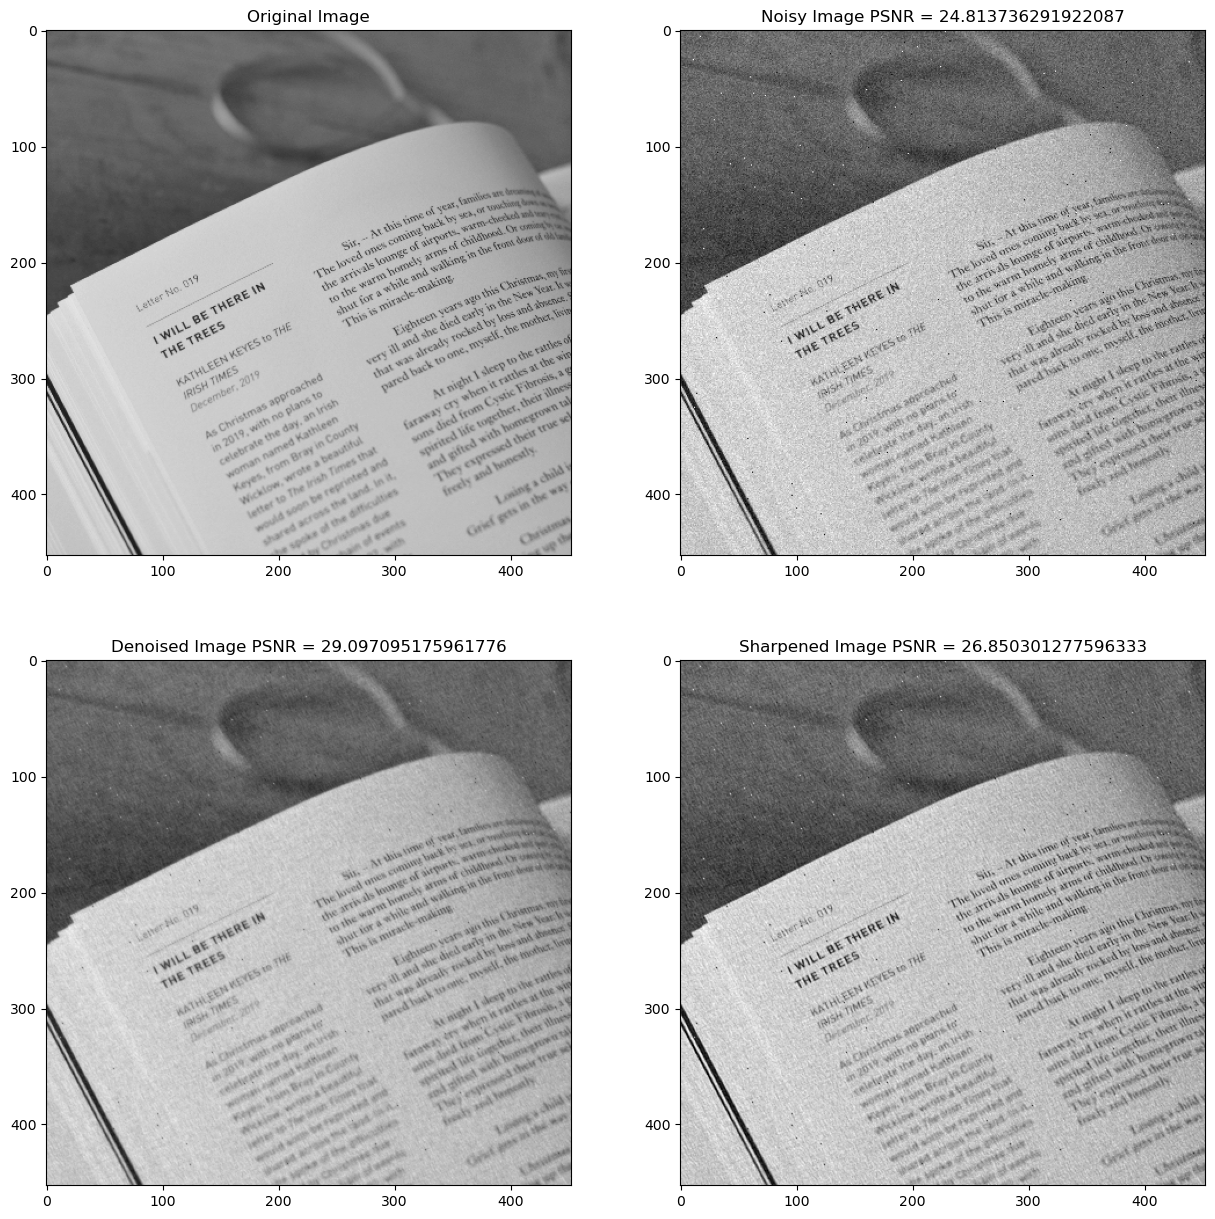

In [13]:
fig = plt.figure(figsize=(15, 15)) 
fig.add_subplot(2, 2, 1)
plt.imshow(image, vmax=1, vmin=0, cmap=plt.cm.gray)
plt.title("Original Image")
fig.add_subplot(2, 2, 2)
plt.imshow(noisy_image, vmax=1, vmin=0, cmap=plt.cm.gray)
plt.title("Noisy Image PSNR = " + str(peak_signal_noise_ratio(image, noisy_image)))
fig.add_subplot(2, 2, 3)
plt.imshow(denoised_image, vmax=1, vmin=0, cmap=plt.cm.gray)
plt.title("Denoised Image PSNR = " + str(peak_signal_noise_ratio(image, denoised_image)))
fig.add_subplot(2, 2, 4)
plt.imshow(sharpened_image, vmax=1, vmin=0, cmap=plt.cm.gray)
plt.title("Sharpened Image PSNR = " + str(peak_signal_noise_ratio(image, sharpened_image)))
plt.savefig("Ridge_reg.jpg")